<a href="https://colab.research.google.com/github/tahmidjamal12/Classification_models/blob/main/Multi_Class_Classsification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing and creating functions

In [ ]:
# Import dependencies
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
# creating plotting functions

def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def accurate_fn(x_seen, x_pred):
  correct = torch.eq(x_seen, x_pred).sum().item()
  return (correct/len(x_pred)) * 100

## Creating multiple classes classification data

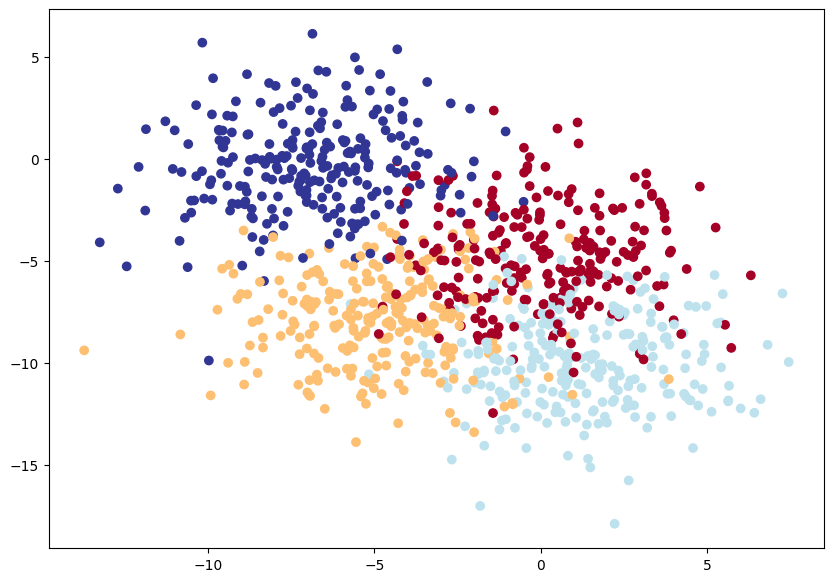

In [ ]:
#set up hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 89

#Creating multiclass data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=2.3,
                            random_state=RANDOM_SEED
                            )

#turn the data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Creating the Model's class

In [ ]:
class MultiModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    """Initializes multi-class classification model.

    Args:
      input features (int): Number of input features to the model
      output_features (int): Number of output features to the model
      hidden_units (int): Number of hidden units between layers, default 16


    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

#Create an instance of blob model
multi_model = MultiModel(2,4,16).to(device)

multi_model

MultiModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

### Loss function and optimizer

In [ ]:
# loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(multi_model.parameters(), lr = 0.15)

## Training and testing model

In [ ]:
# setting randomness and correct devices
torch.manual_seed(89)
torch.cuda.manual_seed(89)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


In [ ]:
#training and testing loop
for epoch in range(epochs):
  multi_model.train()

  y_logits = multi_model(X_blob_train)
  #softmax isnt necessary but cool to have
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accurate_fn(y_blob_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing code
  multi_model.eval()
  with torch.inference_mode():
    test_logits = multi_model(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss =loss_fn(test_logits, y_blob_test)
    test_acc = accurate_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch:  {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch:  0 | Loss:  1.32785 | Acc: 31.62% | Test loss: 1.11545 | Test acc: 48.50%
Epoch:  10 | Loss:  0.67627 | Acc: 74.88% | Test loss: 0.60657 | Test acc: 76.00%
Epoch:  20 | Loss:  0.63242 | Acc: 69.00% | Test loss: 0.71250 | Test acc: 68.50%
Epoch:  30 | Loss:  0.56908 | Acc: 80.88% | Test loss: 0.52896 | Test acc: 74.00%
Epoch:  40 | Loss:  0.54250 | Acc: 82.38% | Test loss: 0.50103 | Test acc: 76.50%
Epoch:  50 | Loss:  0.52354 | Acc: 83.12% | Test loss: 0.48162 | Test acc: 77.50%
Epoch:  60 | Loss:  0.50826 | Acc: 82.88% | Test loss: 0.46611 | Test acc: 79.00%
Epoch:  70 | Loss:  0.49616 | Acc: 82.50% | Test loss: 0.45348 | Test acc: 80.50%
Epoch:  80 | Loss:  0.48500 | Acc: 83.00% | Test loss: 0.44038 | Test acc: 81.00%
Epoch:  90 | Loss:  0.47435 | Acc: 83.75% | Test loss: 0.42531 | Test acc: 81.00%


## Plotting the Model's accuracy

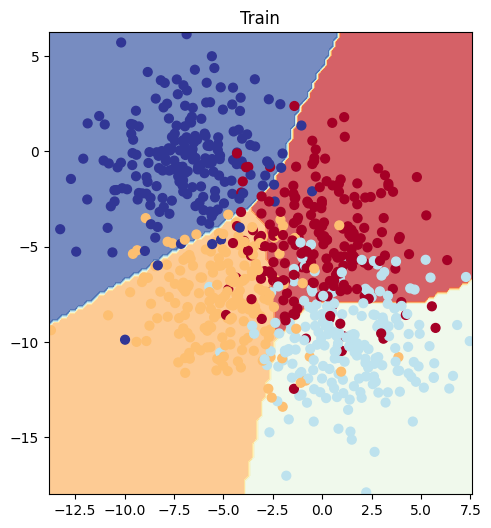

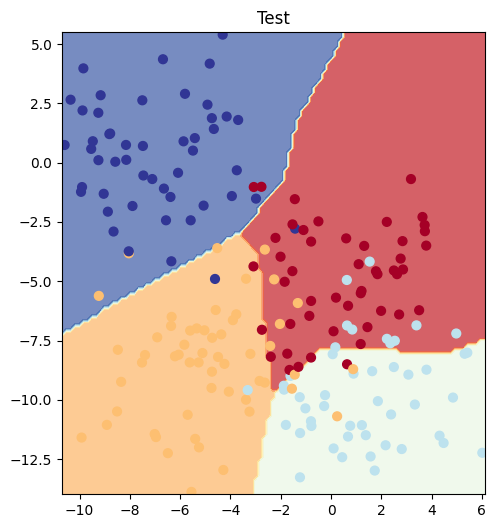

In [ ]:
#plotting the data

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(multi_model, X_blob_train, y_blob_train)
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(multi_model, X_blob_test, y_blob_test)